## Chapter 3 -  Classification

### Multiclass Classification

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             classification_report, 
                             confusion_matrix, f1_score, 
                             precision_recall_curve, roc_curve, roc_auc_score)

def load(fname):
    mnist = None
    try:
        with open(fname, 'rb') as f:
            mnist = pickle.load(f)
            return mnist
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        with open(fname, 'wb') as f:
            mnist = pickle.dump(mnist, f)
        return mnist

In the multiclass classifier problem, the target number of classes extends beyond just 2. There are some classifiers that can handle more than 2 classes while some are strictly binary classifiers. However, we can still use binary classifiers for multiclass problems.

In the MNIST problem where there are 10 classes, we can create a system of multiple binary classifiers (e.g. a 0-detector, a 1-detector etc.). To classify a new image, run through every binary classifier and select the best score. This is known as the <b>one-versus-all (OVA)</b> strategy. The number of classifiers is the same as the number of classes. With 10 classes, we will have 10 classifiers.

Another way is to train a 0v1, 0v2, 1v2 etc. classifier and select the class that has won the most duels / the class with the most number of assignments for each of these classifiers. This is called the <b>one-versus-one (OVO)</b> strategy. The number of classifiers to train here is $\frac{N(N-1)}{2}$ classifiers. 

In [2]:
# Ingest
mnist_data = load('mnist.data.pkl')
X, y = mnist_data['data'], mnist_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In `sklearn`, in a case where $k>2$, the OVA strategy is used by default.

In [3]:
# Train a SGD classifier with 10 classes
clf = SGDClassifier(random_state=0)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Notes: Training took about 2 minutes.

We can see the results for each of the classifiers by using `decision_function`.

In [34]:
# For evaluation
i = 5
Xti = [X_train[i]]
# Get the prediction result
print(clf.predict(Xti))
print()
# Get the decision scores for each class
print(list([m.round(2) for m in clf.decision_function(Xti)[0]]))
print()
for kpred1, kpred2 in list(zip(range(10), clf.decision_function(Xti)[0])):
    print('{} : {:.2f}'.format(str(kpred1), kpred2))
print()
print(y_test[i])


['9']

[-9791.77, -79739.28, -10462.73, -20837.1, -7980.04, -10559.4, -21397.66, -5991.81, -6365.83, -2799.92]

0 : -9791.77
1 : -79739.28
2 : -10462.73
3 : -20837.10
4 : -7980.04
5 : -10559.40
6 : -21397.66
7 : -5991.81
8 : -6365.83
9 : -2799.92

9


`sklearn` has a tool for OVO classification.

In [35]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=0))
ovo_clf.fit(X_train, y_train)


OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=0, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

Note: Training took about 30 seconds

In [39]:
# Find the number of classifiers / duels
print(len(ovo_clf.estimators_))

45


In [40]:
# For evaluation
i = 5
Xti = [X_train[i]]
# Get the prediction result
print(ovo_clf.predict(Xti))
print(ovo_clf.decision_function(Xti)[0])
# Get the decision scores for each class
print(y_test[i])


['9']
[ 6.33333312 -0.33333325  6.33333302  1.66666704  7.33333288  1.66666786
  3.66666757  6.33333286  3.33333191  9.33333302]
9


`RandomForestClassifier` can simply perform the classification to multiple classes without using the OVO or OVA strategy. 

For a new sample, we can find the probability that an observation belongs in each class. The class with the highest probability is the predicted class.

In [41]:
forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Note: Training took about 1 minute

In [46]:
# For evaluation
i = 5
Xti = [X_train[i]]
# Get the prediction result
print(forest_clf.predict(Xti))
# Get the probabilities for the observation existing in each class
for kpred1, kpred2 in list(zip(range(10), forest_clf.predict_proba(Xti)[0])):
    print('{} : {:.2f}'.format(str(kpred1), kpred2))
print(y_test[i])


['9']
0 : 0.01
1 : 0.00
2 : 0.04
3 : 0.01
4 : 0.03
5 : 0.02
6 : 0.00
7 : 0.03
8 : 0.02
9 : 0.84
9


Performance evaluation for each of the models:

In [50]:
# Evaluation: SGD
print(cross_val_score(clf, X_train[:10000], y_train[:10000], cv=3, scoring='accuracy'))
# Note: Took about 3 minutes for all observations

# Evaluation: OVO SGD
print(cross_val_score(ovo_clf, X_train[:10000], y_train[:10000], cv=3, scoring='accuracy'))
# Note: Took about 1 minute for all observations

# Evaluation: Random Forest
print(cross_val_score(forest_clf, X_train[:10000], y_train[:10000], cv=3, scoring='accuracy'))
# Note: Took about 2 minutes for all observations


[0.85632873 0.86558656 0.85808581]
[0.89592082 0.89978998 0.90639064]
[0.9355129  0.94389439 0.94449445]


Conclusion: Random Forest has a lot more success than other algorithms.

Other ways we can improve the algorithm is to perform scaling before doing model fitting. This does improve the SGD classifier score

In [51]:
# Scale before testing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Evaluation: SGD
print(cross_val_score(clf, X_train_scaled[:10000], y_train[:10000], cv=3, scoring='accuracy'))
# Note: Cross Validation took 13 minutes

/Users/bryanlim/.pyenv/versions/3.7.2/envs/botanic/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[0.89622076 0.89738974 0.89408941]


### Error Analysis

One way to evalute the model is to see the errors that it is making. In the 10 digit classification problem, we can observe the confusion matrix.

In [52]:
y_train_predict = cross_val_predict(clf, X_train_scaled, y_train, cv=3)
# Note: Training & prediction took 10 minutes

In [53]:
# Compute the confusion matrix
conf_mx = confusion_matrix(y_train, y_train_predict)
print(conf_mx)

[[5529    0   13   10   10   42   31    7  208    1]
 [   0 6378   34   18    4   42    7    7  186    9]
 [  22   27 5171   82   72   25   72   40  375   12]
 [  24   19  102 5231    1  179   26   42  398   67]
 [  14   14   42   10 5209    5   31   20  320  156]
 [  31   16   23  155   52 4448   77   22  509   56]
 [  26   14   43    2   42   83 5478    8  137    0]
 [  16   12   59   22   43    8    4 5647  160  202]
 [  16   65   39   84    6  125   34   10 5392   44]
 [  25   21   25   52  131   33    1  164  338 5156]]


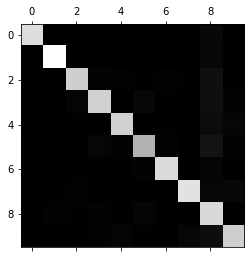

In [54]:
# A way to visualise the confusion matrix is to use matshow.
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Notice that the squares that are not on the main diagnonal are dark. To focus on them, divide each value in the confusion matrix by the number of images in the corresponding class.

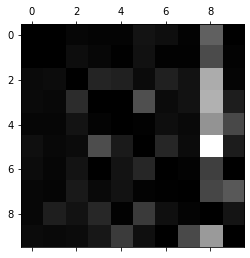

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now, we can see the errors that classifier is making. Recall that rows represent actual values while columns represent predicted values. The columns for 8 are bright (many bright squares for this column) which means this class suffers from the most amount of prediction errors.

The confusion matrix can give us insights on how to improve the classifier. Beyond that, we can see that class separation for 3 and 5 also suffer from high classification error.

Beyond this, we can look at the raw data to see why some classes are more well separated / better predicted while some are weaker.